In [1]:
import pandas as pd
import numpy as np
from numpy.linalg import svd, eig
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib import cm
from sklearn.datasets import load_iris, fetch_olivetti_faces
from sklearn.decomposition import PCA, TruncatedSVD
from pandas.tools.plotting import scatter_matrix

# Always make it pretty.
plt.style.use('ggplot')

%matplotlib inline

# Dimensionality Reduction

### Morning: Principal Component Analysis
- Why reduce dimensionality?
 - Review: the Curse
- What are "principal components"?
- How is PCA used to reduce dimensionality?


### Afternoon: Singular Value Decomposition
- What is it and how is it used for PCA?
- How do you interpret the $U, \Sigma, V$ matrices?
- What are "latent features"?



# What is the dimensionality of this data set?


In [2]:
names= ['mpg', 'cylinders', 'displacement', 'horsepower', 'weight', 'acceleration', 'model', 'origin', 'car_name']
cars = pd.read_csv('data/cars.tsv', delim_whitespace=True, header=None, names=names)
cars.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model,origin,car_name
0,18.0,8,307.0,130.0,3504.0,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165.0,3693.0,11.5,70,1,buick skylark 320
2,18.0,8,318.0,150.0,3436.0,11.0,70,1,plymouth satellite
3,16.0,8,304.0,150.0,3433.0,12.0,70,1,amc rebel sst
4,17.0,8,302.0,140.0,3449.0,10.5,70,1,ford torino


# What is the dimensionality of this data set?
MNIST handwritten digits. Each grayscale image is 28x28
<img src="images/mnist.png" style="width: 500px;" />

Each pixel is a feature, so each image (data point) is a 784-dimensional feature vector.

## Why Reduce Dimensions?
- Combat the **Curse of Dimensionality**
    - Remember how that ruined kNN and clustering?
- Facilitate **Visualization**
    - Most people only want to see 2 or 3 dimensions at a time
- Combine many raw features into a few meaningful latent features
    - More about this in the afternoon! And tomorrow!
- Remove Correlated Features
    - If you have p features, then you have p(p-1)/2 pairs of features. If p=10,000, that’s a lot. Many of those pairs will be correlated.
- Compress your data
    - If you can represent your data in fewer dimensions without losing much information, you have saved some hard drive space.

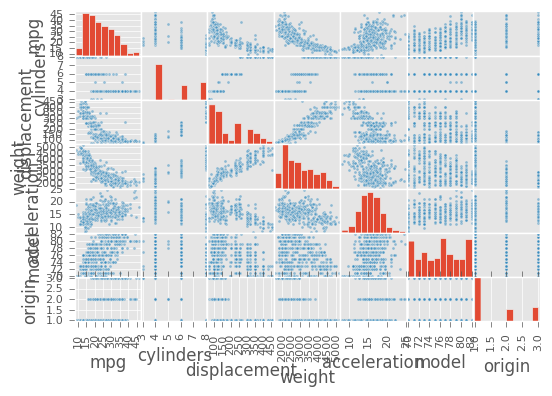

In [3]:
pd.scatter_matrix(cars);

## Some methods for dimensionality reduction
- Subset selection of features; e.g. forward stepwise selection
- LASSO regression
- Relaxed LASSO:
    - (1) do LASSO regression, (2) throw away unused features, (3) do OLS regression
- Neural networks:
    - (black box)
- **Principal Components Analysis (PCA)**
    - In short: find the directions in feature space that account for the most variance in the data


### Introduction to Principal Component Analysis

Let's think of our data $X$ as a point cloud in $p$-dimensional space, and ask the following question:

**Fundamental Question:** How can we find a 1-dimensional representation of our data $X_1$ so that

  - Going from $X$ to $X_1$ is a very simple operation.
  - In some sense, $X_1$ is the *best* one dimensional reconstruction of $X$.

**Discussion:** Consider "Going from $X$ to $X_1$ is a very simple operation".  What are some good candidates for *simple operations*.  The following animation may be suggestive.

![Pca Animation](img/pca.gif)

Image source: http://stats.stackexchange.com/a/140579/74500

#### One-Dimensional PCA

We look for a **line** so that the *projection* of the data $X$ onto that line

  - Results in points minimizing the total squared distance to $X$
  - Results in points with *maximum variance* as a 1-dimensional data set.

In [4]:
N_points = 75

In [5]:
def random_data_set(n=N_points):
    theta = np.random.uniform(low=0, high=2*3.14159)
    rotation = np.array([[np.cos(theta), np.sin(theta)], 
                         [-np.sin(theta), np.cos(theta)]])
    data = np.column_stack([np.random.normal(size=n), 2*np.random.normal(size=n)])
    rotated_data = np.dot(data, rotation)
    return rotated_data

In [6]:
def plot_1dim_pca(ax):
    """Make a plot of:
        - A point cloud rotated to an random angle (blue).
        - The principal component line through the orgin (green).
        - Plot the eigenvector representing the principal component (black).
        - The point cloud projected onto the principal component line (green).
    """
    X = random_data_set()
    pcd = PCA(1).fit(X)
    e = pcd.components_[0]
    # Plot the data set.
    ax.scatter(X[:, 0], X[:, 1])
    # Plot a line for the principal component.
    x = np.linspace(-10, 10, num=3)
    ax.plot(e[0]*x, e[1]*x, color='green', alpha=0.3, linestyle='-')
    # Plot the projections of the data points onto the line.
    X_proj = np.dot(X, e)
    X_reconst = np.array([t*e for t in X_proj])
    ax.scatter(X_reconst[:, 0], X_reconst[:, 1], color="green", alpha=0.5)
    # Plot an arrow for the first principal direction.
    ax.arrow(0, 0, e[0], e[1], head_width=0.33, linewidth=3, head_length=0.5, fc='k', ec='k')
    ax.set(adjustable='box-forced', aspect='equal')
    ax.set_xlim((-5, 5))
    ax.set_ylim((-5, 5))

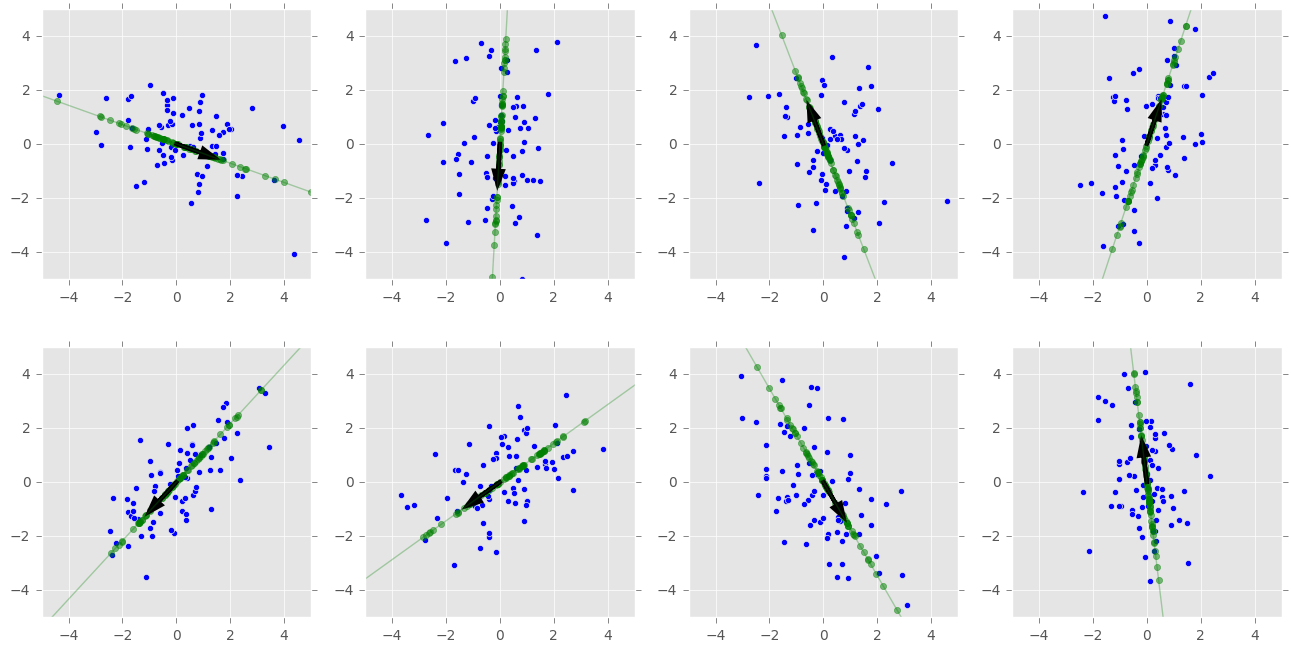

In [7]:
fig, axs = plt.subplots(2, 4, figsize=(16, 8))

for ax in axs.flatten():
    plot_1dim_pca(ax)

In these plots, we superimpose the first principal component onto a random scatter plot.  Notice that:

> The green line is chosen so that the projections of the data points onto this line are **maximally spread out**.

The direction of this line is called the **first principal component** of the data.

#### General Principal Components

**In general** PCA applied to a dataset $X$ returns the best line, plane, 3-space, 4-space, ... so that when $X$ is projected into the subspace

  - The total squared distance from the original data to the projections in minimized.
  - The total variance (i.e. the sum of the variances in all posible orthogonal directions) of the projected dataset is maximal.

In [8]:
def plot_2dim_pca(ax):
    """Make a plot of:
        - A point cloud rotated to an random angle (blue).
        - The principal component lines through the orgin (green).
        - The eigenvectors representing the principal components (black).
        - The point cloud projected onto the principal component lines (green).
    """
    X = random_data_set()
    pcd = PCA(2).fit(X)
    e_1 = pcd.components_[0]
    e_2 = pcd.components_[1]
    # Plot the data set.
    ax.scatter(X[:, 0], X[:, 1])
    # Plot a lines for the principal components.
    x = np.linspace(-10, 10, num=3)
    ax.plot(e_1[0]*x, e_1[1]*x, color='green', alpha=0.3, linestyle='-')
    ax.plot(e_2[0]*x, e_2[1]*x, color='green', alpha=0.3, linestyle='-')
    # Plot the projections of the data points onto the first line.
    X_proj = np.dot(X, e_1)
    X_reconst = np.array([t*e_1 for t in X_proj])
    ax.scatter(X_reconst[:, 0], X_reconst[:, 1], color="green", alpha=0.5)
    # Plot the projections of the data points onto the second line.
    X_proj = np.dot(X, e_2)
    X_reconst = np.array([t*e_2 for t in X_proj])
    ax.scatter(X_reconst[:, 0], X_reconst[:, 1], color="green", alpha=0.5)
    # Plot an arrow for the first principal direction.
    ax.arrow(0, 0, e_1[0], e_1[1], head_width=0.33, linewidth=3, head_length=0.5, fc='k', ec='k')
    ax.arrow(0, 0, e_2[0], e_2[1], head_width=0.33, linewidth=3, head_length=0.5, fc='k', ec='k')
    ax.set(adjustable='box-forced', aspect='equal')
    ax.set_xlim((-5, 5))
    ax.set_ylim((-5, 5))

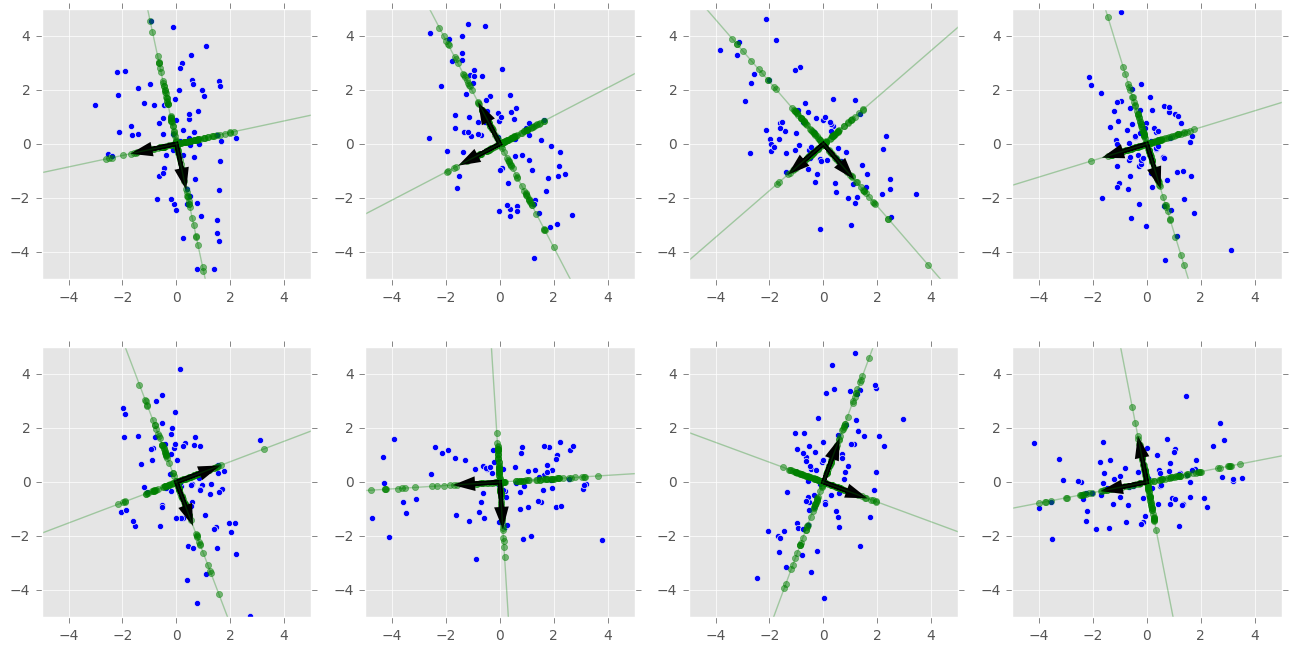

In [9]:
fig, axs = plt.subplots(2, 4, figsize=(16, 8))

for ax in axs.flatten():
    plot_2dim_pca(ax)

In these plots, we superimpose the first and second principal components onto a random scatter plot.  Notice that:

  - The **first principlal component** determines a green line that maximizes the variance of the data's projection.
  - The **second principal component** is orthogonal to the first, and maximizes the projection of the "leftover" data.

### Computing Principal Components

The solution to the problem of finding principal components involves, somewhat surprisingly, the *eigenvalues* and *eigenvectors* of the covariance matrix $X^t X$ of $X$.

**Note:** X must be centered before computing the covariance in this manner.

#### Setup:

$X$ is a dataset, which we represent as a $n \times p$ matrix of numbers.

In [10]:
X = random_data_set(n=50)
X[:5, :]

array([[ 0.21359845, -0.22698647],
       [-3.58010138,  3.349046  ],
       [-1.51201897,  4.51350537],
       [-0.29061933, -0.63414177],
       [ 2.9292926 , -1.69718157]])

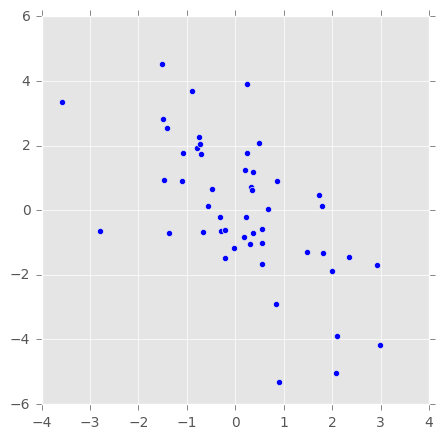

In [11]:
fig, ax = plt.subplots(1, figsize=(5, 5))

ax.scatter(X[:, 0], X[:, 1])

#### Step 1: Center the Matrix.

**Centering** the matrix is the process of subracting the column means from the columns themselves.  This results in a new matrix with column means zero.

In [12]:
np.mean(X, axis=0)

array([ 0.13977803,  0.02070211])

In [13]:
X_centered = X - np.mean(X, axis=0)
print(np.mean(X_centered, axis=0))

[  4.99600361e-18  -5.77315973e-17]


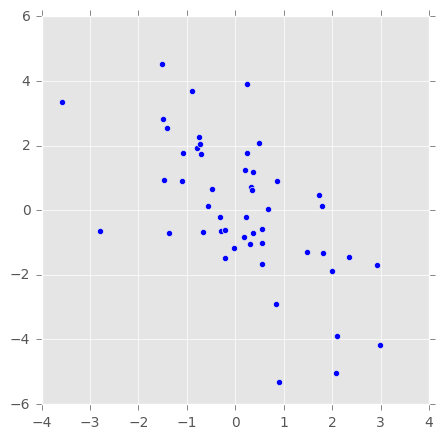

In [14]:
fig, ax = plt.subplots(1, figsize=(5, 5))

ax.scatter(X[:, 0], X[:, 1]);

#### Step 2: Compute the sample covariance matrix.

The sample covariance matrix is $M = \frac{1}{n} X^t X$.

In [15]:
M = np.dot(X.T, X) * (1/float(X.shape[0]))
M

array([[ 1.79711948, -1.77662956],
       [-1.77662956,  4.555084  ]])

#### Step 3: Compute the Eigenvectors and Eigenvalues of M

The eigenvectors, when ordered in order of decreasing eigenvalue, are the principal components of $X$.

**Note:**
  - Since $M$ is a symmetric, it has a full set of $p$ eigenvectors.
  - Since $M$ is non-negative definite,  the eigenvalues are non-negative numbers.

In [16]:
e_values, e_vectors = eig(M)
print("The eigenvectors of M are:")
print(e_vectors)
print("The eigenvlaues of M are {}".format(e_values))

The eigenvectors of M are:
[[-0.89809612  0.43979922]
 [-0.43979922 -0.89809612]]
The eigenvlaues of M are [ 0.92710092  5.42510255]


### Intermission: Eigenvectors

Recall that the **eigenvectors** of $M$ are vectors $v$ that satisfy a relationship like:

$$ M v = \lambda v $$

I.e., the matrix $M$ acts as a **scaling** on the vector $v$.

In [17]:
np.dot(M, e_vectors[:, 0]) / e_vectors[:, 0]

array([ 0.92710092,  0.92710092])

In [18]:
np.dot(M, e_vectors[:, 1]) / e_vectors[:, 1]

array([ 5.42510255,  5.42510255])

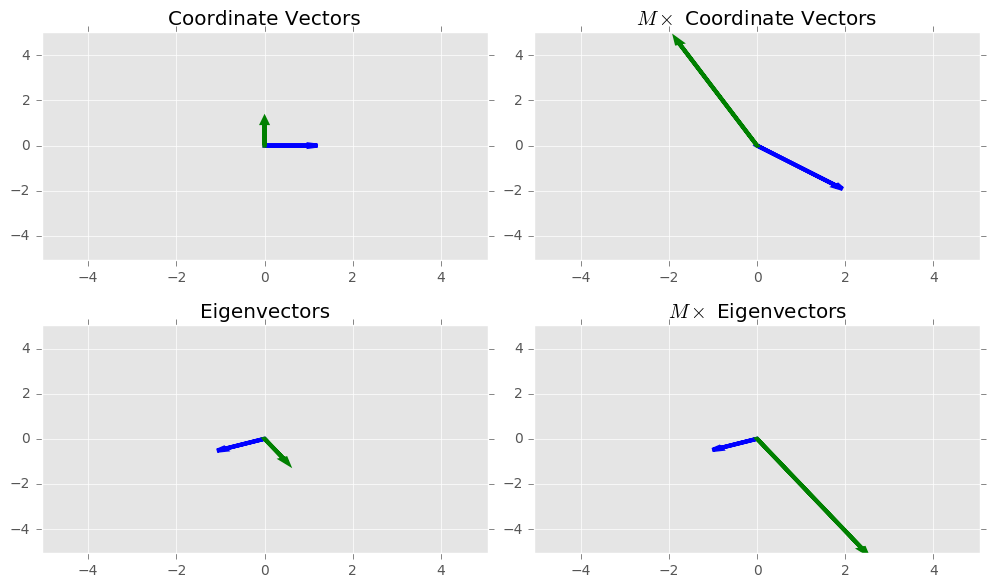

In [19]:
fig, axs = plt.subplots(2, 2, figsize=(10, 6))

coord_vectors = np.array([[1, 0], [0, 1]])
coord_image = np.dot(M, coord_vectors)
e_image = np.dot(M, e_vectors)

# Set coordinate ranges to the maximal possible arrow position
max_coord = max(np.max(coord_vectors), np.max(coord_image), np.max(e_image))
for ax in axs.flatten():
    ax.set_xlim(-max_coord - 0.5, max_coord + 0.5)
    ax.set_ylim(-max_coord - 0.5, max_coord + 0.5)

# Plot the coordiante vectors and thier images.
axs[0, 0].arrow(0, 0, coord_vectors[0, 0],  coord_vectors[1, 0],
                head_width=0.1, linewidth=3, head_length=0.2, fc='b', ec='b')
axs[0, 0].arrow(0, 0, coord_vectors[0, 1], coord_vectors[1, 1],
                head_width=0.1, linewidth=3, head_length=0.2, fc='g', ec='g')
axs[0, 0].set_title("Coordinate Vectors")
axs[0, 1].arrow(0, 0, coord_image[0, 0],  coord_image[1, 0],
                head_width=0.1, linewidth=3, head_length=0.2, fc='b', ec='b')
axs[0, 1].arrow(0, 0, coord_image[0, 1], coord_image[1, 1],
                head_width=0.1, linewidth=3, head_length=0.2, fc='g', ec='g')
axs[0, 1].set_title("$M \\times$ Coordinate Vectors")


# Plot the eigenvectors and thier images.
axs[1, 0].arrow(0, 0, e_vectors[0, 0],  e_vectors[1, 0],
                head_width=0.1, linewidth=3, head_length=0.2, fc='b', ec='b')
axs[1, 0].arrow(0, 0, e_vectors[0, 1], e_vectors[1, 1],
                head_width=0.1, linewidth=3, head_length=0.2, fc='g', ec='g')
axs[1, 0].set_title("Eigenvectors")
axs[1, 1].arrow(0, 0, e_image[0, 0],  e_image[1, 0],
                head_width=0.1, linewidth=3, head_length=0.2, fc='b', ec='b')
axs[1, 1].arrow(0, 0, e_image[0, 1], e_image[1, 1],
                head_width=0.1, linewidth=3, head_length=0.2, fc='g', ec='g')
axs[1, 1].set_title("$M \\times$ Eigenvectors")

plt.tight_layout()

Above, we see that the effect of multiplying the matrix $M$ by coordinate vectors is difficult to understand, the coordinate vectors are rotated and scaled, each by a different amount.

On the other hand, the eigenvectors of $M$ are much better behaved when multiplied by $M$, the directon of the eigenvectors are preserved, but they are streched or shrunk.

Let's plot the eigenvectors of $M$ on top of the centered data set to see how they relate to the scatterplot of the data

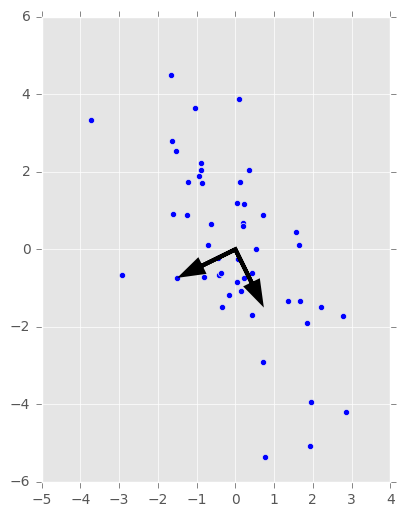

In [20]:
fig, ax = plt.subplots(1, figsize=(8, 6))

ax.scatter(X_centered[:, 0], X_centered[:, 1])
ax.arrow(0, 0, e_vectors[0, 0], e_vectors[1, 0],
         head_width=0.33, linewidth=3, head_length=0.5, fc='k', ec='k')
ax.arrow(0, 0, e_vectors[0, 1], e_vectors[1, 1],
         head_width=0.33, linewidth=3, head_length=0.5, fc='k', ec='k')
_ = ax.set(adjustable='box-forced', aspect='equal')

### Summary:

  - The Principal Components algorithm computes the *eigenvectors* and *eigenvalues* of the matrix $X^t X$.
  - Each eigenvector is called a *principal component* of $X$.
  - Projecting onto the first $k$ principal components creates the **best k dimensional reconstruction of the data**.

## PCA In Practice

In practice, we use `sklearn.decomposition.PCA` to find principal components.

In [21]:
pcd = PCA(2).fit(X)

Sklearn returns a `PCA` returns an object with a `components_` attribute.

In [22]:
pcd.components_

array([[ 0.43865024, -0.89865787],
       [-0.89865787, -0.43865024]])

The `components_` attribute is an orthogonal matrix containing (as rows) the eigenvalues of the correlation matrix.  That is, the *principal components*.

Let's call the matrix of principal components $E$.

### Properties of Principal Componenets

1. Taking the first $k$ rows of $E$ gives (a basis for) the "best" $k$ dimensional subspace.  We call this subset matrix $E_{1:k}$.

2. "Best" above means: projecting the dataset onto this subspace preserves the **most variance in the data** out of all possible such projections.

3. The matrix multiplication $XE_{1:k}^T$ gives the *coefficients* of the "best" reconstruction of $X$ in the basis $E_k$.

4. The matrix multiplication $(X E_{1:k}^T) E_{1:k}$ gives the "best" reconstruction of $X$ as a $k$ dimensional object.  That is, this reconstructs $X$ as a matrix with $k$ columns.

Additionally, the `explained_variance_` attribute contains the total variance of the *projected* dataset.

Each of the numbers in `explained_variance_` is an *eigenvalue* of the covariance matrix $X^t X$.

5. The **eigenvalues** of the covaraince matrix measure the varaince of the projection of the data onto the associated eigenvector (principal component).

### What Principal Component Analysis IS For

So, **the purpose of PCA is to approximately reconstruct data sets as a lower dimensional object.**

Applications of this include:

  - Visualization.
  - Clustering.
  - Data Compression.
  - Mathematical analysis of the properties of regression modeling.

### Example: The Best Scatterplot of Iris

Let's construct a "best" scatterplot of the iris dataset using PCA to project

```
Four dimensional iris data => Best two dimensional reconstruction
                           => Best two dimensional scatterplot
```

In terms of the above discussion we are plotting the *expression of $X$ in the principal componenet basis*.

$$ X E_2^t $$

In [23]:
pcd = PCA(2).fit(iris_data.values)
iris_reduced = np.dot(iris_data.values, pcd.components_.T)

NameError: name 'iris_data' is not defined

In [ ]:
fig, ax = plt.subplots(1, figsize=(8, 6))

ax.scatter(iris_reduced[:, 0], iris_reduced[:, 1], 
           color=np.array(["red", "green", "blue"])[iris_type])
ax.set_title("Scatterplot of Iris Data in PCA 2-Plane")
ax.set_xlabel("First Principal Component")
ax.set_ylabel("Second Principal Component")

### Example: Eigenfaces: Reconstructing Faces.

As an example of *very* high dimensional data, we introduce the `faces` data set.

An extended version of this example is available in the sklearn docs here: http://scikit-learn.org/stable/auto_examples/decomposition/plot_faces_decomposition.html

In [ ]:
dataset = fetch_olivetti_faces(shuffle=True, random_state=154)
faces = dataset.data

n_samples, n_features = faces.shape

# Global centering
faces_centered = faces - faces.mean(axis=0)

# Local centering
faces_centered -= faces_centered.mean(axis=1).reshape(n_samples, -1)

In [ ]:
n_row, n_col = 2, 3
n_components = n_row * n_col
image_shape = (64, 64)

def plot_gallery(title, images, n_col=n_col, n_row=n_row):
    plt.figure(figsize=(2.0 * n_col, 2.26 * n_row))
    plt.suptitle(title, size=16)
    for i, comp in enumerate(images):
        plt.subplot(n_row, n_col, i + 1)
        vmax = max(comp.max(), -comp.min())
        plt.imshow(comp.reshape(image_shape), cmap=plt.cm.gray,
                   interpolation='nearest',
                   vmin=-vmax, vmax=vmax)
        plt.xticks(())
        plt.yticks(())
    plt.subplots_adjust(0.01, 0.05, 0.99, 0.93, 0.04, 0.)

In [ ]:
plot_gallery("Centered Olivetti faces", faces_centered[:n_components])

Each of these images is stored as a numpy array.

Each entry in the array measures *one* pixel intensity.

In [ ]:
first_face = faces_centered[0].reshape(image_shape)
print(first_face)
plt.imshow(first_face, cmap=cm.gray)

Each image is a $64 \times 64$ array, and so is represented as a $4096$ dimensional object.

Let's apply PCA to the faces dataset to lower the dimensionality.

In [ ]:
faces_pcd = PCA(100).fit(faces_centered)

The columns in the $E^t$ matrix (i.e. `faces_pcd.components_.T`) are called **eigenfaces**.

In [ ]:
fig, axs = plt.subplots(2, 3, figsize=(12, 6))

for ax, i in zip(axs.flatten(), range(6)):
    eigenface = faces_pcd.components_[i, :].reshape(image_shape)
    ax.imshow(eigenface, cmap=cm.gray)
    ax.set_title("{}'th Eigenface".format(i))
    ax.set_xticks(())
    ax.set_yticks(())
    
fig.tight_layout()

**Question:** What facial features seem to be captured in the first few eigenfaces?  Why do you think this may be so?

Let's do our reconstruction procedure with the face data.  This lets us create **smaller dimensional faces**.

In [ ]:
def reduce_face_data(n_dim):
    eigenvalues = faces_pcd.components_[:n_dim, :].T
    faces_reduced = np.dot(np.dot(faces_centered, eigenvalues), eigenvalues.T)
    return faces_reduced

In [ ]:
fig, axs = plt.subplots(2, 3, figsize=(13, 6))

for ax, dim in zip(axs.flatten(), [1, 2, 4, 10, 25, 50]):
    reduced_data = reduce_face_data(dim)
    first_face = reduced_data[0].reshape(image_shape)
    ax.imshow(first_face, cmap=cm.gray)
    ax.set_title("Face Reconstructed with {} PCA\nComponents".format(dim))
    ax.set_xticks(())
    ax.set_yticks(())
    
fig.tight_layout()

**Discussion:** When applying PCA to reduce the dimensionality of a data set, we have to choose a *number of dimensions* to keep.  What kind of concerns should we consider when choosing this number?

### What Principal Componenets Analysis is NOT For

There is an unfortunately popular method which combines PCA with regression, with the intent of improving the generalization properties of the regression.  It is called **Principal Component Regression** and it goes like this:

**Setup**: You have a matrix $X$ and a response $y$, and you want to fit a regression to predict $y$ from $X$.

**Procedure**:
1. Do PCA on $X$, let $E$ be the matrix of principal components.
2. Discard some of the principal components, get the matrix $E_{1:k}$.
3. Regress $y$ on $E_{1:k}$.

**Discussion:** Critique this procedure, pros and cons.

For details on why **not** to use selection of principal components as a regularization strategy in regression [see this paper](http://www.uvm.edu/~rsingle/stat380/F04/possible/Hadi%2BLing-AmStat-1998_PCRegression.pdf) and [this paper](http://automatica.dei.unipd.it/public/Schenato/PSC/2010_2011/gruppo4-Building_termo_identification/IdentificazioneTermodinamica20072008/Biblio/Articoli/PCR%20vecchio%2082.pdf).

[This question](http://stats.stackexchange.com/questions/101485/examples-of-pca-where-pcs-with-low-variance-are-useful) gives real life examples of data sets where PCR fails because $y$ is only related to the **low variance** principal components.

## Singular Value Decomposition - Afternoon Lecture

**Opening Question:** http://stats.stackexchange.com/questions/239518/logistic-regression-with-lasso-versus-pca

### The Singular Value Decomposition

There is a matrix factorization closely related to PCA, the SVD decomposition.

**Any** $n \times p$ matrix $X$ can be factored as follows

$$ X = U S V $$

Where

  - $U$ is a $n \times n$ orthogonal matrix.
  - $S$ is a $n \times p$ matrix with non-zero entries on the diagonal *only*.
  - $V$ is a $p \times p$ orthogonal matrix.

### Intermission: Orthogonal Matricies

An **orthogonal matrix** is one with the following property:
    
> Any vector $v$, when multiplied by an orthogonal matrix, is simply rotated.

We say that an orthogonal matrix **acts as a rotation**.

It's easy to crate $2 \times 2$ orthogonal matricies.  For any angle $\theta$, the matrix

$$ M_{\theta} =  \left( \begin{array}{cc} 
\cos \theta & - \sin \theta  \\       
sin \theta & cos \theta \\
\end{array} \right) $$

is orthogonal.  

In [ ]:
thetas = np.linspace(0, 2*np.pi, num=8)
coord_vectors = np.array([[1, 0], [0, 1]])


fig, axs = plt.subplots(2, 4, figsize=(14, 6))

for i, (theta, ax) in enumerate(zip(thetas, axs.flatten())):
    M = np.array([[-np.sin(theta), np.cos(theta)], 
                  [np.cos(theta), np.sin(theta)]])
    image_vectors = np.dot(M, coord_vectors)
    ax.arrow(0, 0, image_vectors[0, 0], image_vectors[1, 0],
            head_width=0.33, linewidth=3, head_length=0.5, fc='g', ec='g')
    ax.arrow(0, 0, image_vectors[0, 1], image_vectors[1, 1],
            head_width=0.33, linewidth=3, head_length=0.5, fc='b', ec='b')
    ax.set_title("$\\theta = \\frac{{2\\pi}}{{7}} \\cdot {}$".format(i))
    ax.set_xlim(-2, 2)
    ax.set_ylim(-2, 2)
    
plt.tight_layout()

A closely related, and more common, definition of an orthogonal matrix is the following:
    
> An orthogonal matrix $M$ is any matrix satisfying the equation $M^t M = I$.

**Exercise**: Verify that the $2 \times 2$ matrix of sins and cosines above is orthogonal by computing $M_{\theta}^t M_{\theta}$ and using some basic trigonometric identities.

So the SVD ddecomposition:
    
$$ X = U S V $$

factors $X$ as three matricies:
    
  - $V$ is orthogonal, hence a rotation, followed by...
  - $S$ is quasi diagonal, so a scaling, followed by...
  - $U$ is orthogonal, so a rotation.

![SVD decomposition](img/svd.png)

Image Source: https://en.wikipedia.org/wiki/Singular_value_decomposition

The $S$ matrix has positive diagonal entries, these are called the **singular values** of $X$, they are closely related to eigenvalues.

So, for a $4 \times 2$ matrix $X$, the singular value matrix would look like:

$$ S =  \left( \begin{array}{cc} 
\sigma_1 & 0  \\       
0 & \sigma_2 \\
0 & 0 \\
0 & 0 \\
\end{array} \right) $$

and for a $6 \times 3$ like:

$$ S =  \left( \begin{array}{cc} 
\sigma_1 & 0 & 0  \\       
0 & \sigma_2 & 0 \\
0 & 0 & \sigma_3 \\
0 & 0 & 0 \\
0 & 0 & 0 \\
0 & 0 & 0 \\
\end{array} \right) $$

### Example: Image Reconstruction From Singular Values

Recall how we used PCA to "approximately reconstruct" a matrix $M$ from its first few principal components.  We can do the same thing with SVD

$$ X \approx U S_{k} V $$

Here, $S_{k}$ is the matrix created from $S$ by setting **all but the first $k$ singular values to zero**.

In an earlier example we reconstructed faces with only the first few principal components, here we reconstruct a face with only the first few **singular values**.

In [ ]:
ig, axs = plt.subplots(2, 3, figsize=(13, 6))
U, S, VT = svd(faces_centered)

for ax, dim in zip(axs.flatten(), [1, 2, 4, 10, 25, 50]):
    S_reduced = np.zeros(faces_centered.shape)
    np.fill_diagonal(S_reduced, S)
    # Set all but first dim singular values equal to zero.
    S_reduced[:, dim:] = 0
    faces_reconstructed = np.dot(U, np.dot(S_reduced, VT))
    first_face_reconstructed = faces_reconstructed[0].reshape(image_shape)
    ax.imshow(first_face_reconstructed, cmap=cm.gray)
    ax.set_title("Face Reconstructed with {} SVD\nComponents".format(dim))
    ax.set_xticks(())
    ax.set_yticks(())

plt.tight_layout()

If you scroll up to the PCA reconstructed faces from before, these look remarkably similar, hinting at a deeper connection.

## SVD for topic analysis

We can use SVD to determine what we call ***latent features***. This will be best demonstrated with an example.

### Example

Let's look at users ratings of different movies. The ratings are from 1-5. A rating of 0 means the user hasn't watched the movie.

|       | Matrix | Alien | StarWars | Casablanca | Titanic |
| ----- | ------ | ----- | -------- | ---------- | ------ |
| **Alice** |      1 |     2 |        2 |          0 |      0 |
|   **Bob** |      3 |     5 |        5 |          0 |      0 |
| **Cindy** |      4 |     4 |        4 |          0 |      0 |
|   **Dan** |      5 |     5 |        5 |          0 |      0 |
| **Emily** |      0 |     2 |        0 |          4 |      4 |
| **Frank** |      0 |     0 |        0 |          5 |      5 |
|  **Greg** |      0 |     1 |        0 |          2 |      2 |

Note that the first three movies (Matrix, Alien, StarWars) are Sci-fi movies and the last two (Casablanca, Titanic) are Romance. We will be able to mathematically pull out these topics!

Let's do the computation with Python.

In [ ]:
rating_matrix = np.array([
              [1, 2, 2, 0, 0],
              [3, 5, 5, 0, 0],
              [4, 4, 4, 0, 0],
              [5, 5, 5, 0, 0],
              [0, 2, 0, 4, 4],
              [0, 0, 0, 5, 5],
              [0, 1, 0, 2, 2]])

movies = ['TheMatrix', 'Alien', 'StarWars', 'Casablanca', 'Titanic']
users = ['Alice', 'Bob', 'Cindy', 'Dan', 'Emily', 'Frank', 'Greg']
ratings_df = pd.DataFrame(rating_matrix, index=users, columns=movies)
print(ratings_df)

Numpy can compute the full SVD.

In [ ]:
U, sigma, VT = svd(rating_matrix)

In [ ]:
U, sigma, VT = (np.around(x, 2) for x in (U, sigma, VT))

U_df = pd.DataFrame(U, index=users)
VT_df = pd.DataFrame(VT, columns=movies)

In [ ]:
print(U_df.shape)
print(sigma.shape)
print(VT_df.shape)

The VT matrix has columns indexed by movies.

In [ ]:
print(VT_df)

We can interpret the *rows* of this matrix as some latent features.  There is *something* about these movies that is

  - Being measured in each row.
  - Being inferred from how users rated the movies as a whole.

For example, the **first row** seems to draw a strong distinction between science fiction and romantic movies.

The U matrix has rows indexed by *users*.

In [ ]:
print(U_df)

Each of the rows in this matrix contains *weights*, they measure how important wach *latent feature* is to each user's ratings.

**Note:** that the last two columns of this matrix *do not matter* for reconstructing X.  These are the columns for which the associated rows of the singular value matrix are **completely zero**.

If we want to figure out an approximation of the user's rating of the movies using **only** the first two latent features, we can zero out all but the first two singular values.

In [ ]:
# Zero out all but the first two singular values
sigma_reduced = np.zeros(rating_matrix.shape)
np.fill_diagonal(sigma_reduced, sigma)
sigma_reduced[:, 2:] = 0

# Reoconstruct the ratings matrix
ratings_reconstructed = np.dot(np.dot(U, sigma_reduced), VT)

ratings_reconstructed_df = pd.DataFrame(ratings_reconstructed, index=users, columns=movies)
print(ratings_reconstructed_df)
print(ratings_df)

This seems to be a pretty good reconstruction of the ratings matrix, even though we only kept two singular values.

If we investigate, the first two singular values are by far the largest:

In [ ]:
print(sigma)

We seem to have picked up some **negative** ratings, which is weird.  Tomorrow we will study a procedure to fix this issue.

### The Relationship Between PCA and SVD

The PCA algorithm can be expressed pithily as the following matrix equation

$$ X^t X = E^t D E $$

where

  - $E$ is the matrix of eigenvectors of $X^t X$ (i.e. principal components, stored in the rows as `sklearn` does).
  - $D$ is a *diagonal* matrix.  The diagonal entries are the eigenvalues of $X^t X$.
  
See the appendix to the lecture for a proof of this fact.

Suppose that we factor $X$ into its singular value decomposition

$$ X = U S V $$

We can plug this into $X^t X$ and derive a relationship between PCA and the SVD factorization.

$$ X^t X = (U S V^t)^t (U S V^t) = V S^t U^t U S V^t $$

But $U$ is orthogonal, so the inner $U^t U$ is the identity matrix:

$$ X^t X = V S^t S V^t $$

Recall that $S$ is $n \times p$ a matrix like this:
    
$$ S =  \left( \begin{array}{cc} 
\sigma_1 & 0 & 0  \\       
0 & \sigma_2 & 0 \\
0 & 0 & \sigma_3 \\
0 & 0 & 0 \\
0 & 0 & 0 \\
0 & 0 & 0 \\
\end{array} \right) $$



**Exercise**: Compute $S^t S$ for this matrix.

So, $S^t S$ is a $p \times p$ matrix like this:
    
$$ S =  \left( \begin{array}{cc} 
\sigma_1^2 & 0 & 0  \\       
0 & \sigma_2^2 & 0 \\
0 & 0 & \sigma_3^2 \\
\end{array} \right) $$

Comparing the two expressions for $X^t X$

#### PCA

$$ X^t X = E^t D E $$

#### SVD

$$ X^t X = V S^t S V^t $$

We duduce the following

#### Relationship between PCA and SVD

$$ E^t = V $$
$$ D = S^t S $$

So the **eigenvectors** from PCA are the **columns** of the matrix V.

And, the **eigenvalues** from PCA are the **squares of the singular values**.

### Why PCA With SVD?

While the above shows its **possible** to compute the principal components with SVD, it does not argue that it is **benificial**.  Let's look at a hypothetical example.

Suppose our data set $X$ contains grayscale image data:

  - $500$ images.
  - Each image is $200 \times 200$ pixels.  So, $40,000$ total pixels.

Therefore, $X$ is a $500 \times 40,000$ matrix.  Many, many more columns than rows.

**Note:** This is commonly called the $p \gg n$ situation.

Now, **PCA** needs to compute the matrix $X^t X$.

This is a $40,000 \times 40,000$ matrix, so it has $1,600,000,000 = 1.6 \times 10^9$ entries.

One floating point number is:
  - $64$ bits (on a modern computer)
  - $8$ bytes (each byte is $8$ bits).

So, $X^t X$ takes

$$ 8 \times 1.6 \times 10^9 = 12.8 \times 10^9 $$

bytes of data to store.  This is $12.8$ gigabytes.  **A huge amount of data**.

SVD **does not have to compute the $X^t X$ matrix, it operates completely on $X$ itself**.  Much more efficient.